In [6]:
print("Last updated: $(read(`date`, String))")

Last updated: Fri Aug 14 21:39:53 PDT 2020


## GP for binary classification (in Turing)

$$
\begin{eqnarray}
y_n \mid p_n &\sim& \text{Bernoulli}(p_n), \text{ for } n=1,\dots, N \\
\text{logit}(\mathbf{p}) &=& \mathbf{L} \cdot \boldsymbol{\eta} + \beta, \text{ where }
\mathbf{L} = \text{cholesky}(\mathbf{K}) \\
\eta_n &\sim& \text{Normal(0, 1)}, \text{ for } n=1,\dots,N \\
\beta &\sim& \text{Normal(0, 1)} \\
\alpha &\sim& \text{LogNormal}(0, 1) \\
\rho &\sim& \text{LogNormal}(0, 1) \\
\end{eqnarray}
$$

Note: 
- $\mathbf{K}$ is an $N\times N$ covariance matrix where
  $K_{n,m} = \alpha^2\exp\left(-{\left\lVert\mathbf{x}_n - \mathbf{x}_m\right\rVert}^2_2\big/\rho^{2}\right)$.
- Each $\mathbf{x}_n$ is an observed 2-dimensional locations, for $n=1,\dots,N$.
- The model above is the same as the more explicit model below. But the model above mixes slowly with ADVI, HMC, and NUTS; while the model above mixes much more quickly.

$$
\begin{eqnarray}
y_n \mid p_n &\sim& \text{Bernoulli}(p_n), \text{ for } n=1,\dots, N \\
\text{logit}(\mathbf{p}) &\sim& \text{MvNormal}(\beta \cdot \mathbf{1}_N, K) \\
\beta &\sim& \text{Normal(0, 1)} \\
\alpha &\sim& \text{LogNormal}(0, 1) \\
\rho &\sim& \text{LogNormal}(1, 1) \\
\end{eqnarray}
%
$$

In [7]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [8]:
# Import Libraries
using Turing
using Turing: Variational
using Distributions
using AbstractGPs, KernelFunctions
using PyPlot
using StatsFuns
using JSON3
using Flux
using ProgressBars
import Random
import LinearAlgebra

In [40]:
# Define a kernel.
function sqexpkernel(alpha::Real, rho::Real)
    alpha^2 * transform(SqExponentialKernel(), 1/(rho*sqrt(2)))
end

@model function GPClassify(y, X, eps=1e-6)
    # Priors.
    alpha ~ LogNormal(0, 1)
    rho ~ LogNormal(0, 1)
    beta ~ Normal(0, 1)  # intercept.

    # Realized covariance function
    kernel = sqexpkernel(alpha, rho) + eps * EyeKernel()
    K = kernelmatrix(kernel, X, obsdim=1)
    
    # Latent function.
    eta ~ filldist(Normal(0, 1), length(y))
    f = LinearAlgebra.cholesky(K).L * eta
    # NOTE: The following more explicit form mixes very poorly.
    # f ~ MvNormal(K)  # mean=0, covariance=K.
    
    # Sampling Distribution.
    y .~ Bernoulli.(logistic.(f .+ beta))
end;

In [10]:
# For getting quantiles along array dimensions
quantiles(X, q; dims) = mapslices(x -> quantile(x, q), X, dims=dims)

# To extract parameters from ADVI model.
function make_extractor(m, q; nsamples=300)
    qsamples = rand(q, nsamples)
    _, sym2range = Variational.bijector(m; sym_to_ranges=Val(true))
    return sym -> qsamples[collect(sym2range[sym][1]), :]
end;

function plot_data(X, y; edgecolors=nothing)
    colors = ["blue", "red"]
    plt.scatter(X[:, 1], X[:, 2], color=colors[y .+ 1], edgecolors=edgecolors)
end;

# Function for plotting parameter posterior.
function plot_post(samples, name; bins=nothing, suffix="")
    param = samples[name]
    plt.hist(param, density=true, bins=bins)
    plt.xlabel(name)
    plt.ylabel("density")
    if suffix !== ""
        suffix = "($(suffix))"
    end
    plt.title("Histogram of $(name) $(suffix)");
end;

In [11]:
function makegrid(xmin, xmax, ymin, ymax, ngrid; return_all=false)
  ngrid = floor(Int, sqrt(ngrid))
  grid = [[i, j]
          for i in range(xmin, xmax, length=ngrid),
          j in range(ymin, ymax, length=ngrid)]
  out =  Matrix(hcat(vec(grid)...)')
    
  if return_all
    return out, grid
  else
    return out
  end
end;

In [12]:
function gp_predict(postsamps, X, y, nnew; eps=0, prob=true, eps_gp=1e-6)
    xmin = minimum(X, dims=1)
    xmax = maximum(X, dims=1)
    Xnew, grid = makegrid(xmin[1]-eps, xmax[1]+eps,
                          xmin[2]-eps, xmax[2]+eps,
                          nnew, return_all=true)
    alpha = postsamps[:alpha]
    rho = postsamps[:rho]
    beta = postsamps[:beta]
    nsamps = length(alpha)
    # f = postsamps[:f]
    eta = postsamps[:eta]
        
    ps = [let
            kernel = sqexpkernel(alpha[i], rho[i])
            kernel += eps_gp * EyeKernel()
            K = kernelmatrix(kernel, X, obsdim=1)
            gp = GP(beta[i], kernel)
            # pfx = posterior(gp(X'), f[:, i])
            f = LinearAlgebra.cholesky(K).L * eta[:, i]
            pfx = posterior(gp(X'), f)
            logit_p = rand(pfx(Xnew'))
            prob ? logistic.(logit_p) : logit_p
         end for i in ProgressBar(1:nsamps)];
    ps = hcat(ps...)
    return ps, Xnew, grid
end;

In [13]:
function plot_kernel_params(post_samples, kernel_params; bins=nothing, figsize=(8,3))
    plt.figure(figsize=figsize)
    nparams = length(kernel_params)
    for i in 1:nparams
        param = kernel_params[i]
        plt.subplot(1, nparams, i)
        plot_post(post_samples, param, bins=bins);
    end
    plt.tight_layout()
end;

In [14]:
function plot_uq(postsamps, X, y, algo;
                 nnew=100, eps=0.2, figsize=(10, 8),
                 kernel_params=nothing, eps_gp=1e-6,
                 color_res=100, color_res_sd=100, return_stuff=false,
                 data_edgecolors=nothing, vmin_sd=0, vmax_sd=nothing, prob=true)
    nsamps = postsamps[:alpha]
    ps, Xnew, grid = gp_predict(postsamps, X, y, nnew, eps=eps, prob=prob, eps_gp=eps_gp)
    
    plt.figure(figsize=figsize)
    gs = [[g[i] for g in grid] for i in 1:2]
    
    # Plot mean function.
    plt.subplot(2, 2, 1)
    if prob
        plt.contourf(gs[1], gs[2], reshape(mean(ps, dims=2), size(gs[1])...),
                     color_res, cmap=plt.get_cmap("bwr"), vmin=0, vmax=1)
    else
        plt.contourf(gs[1], gs[2], reshape(mean(ps, dims=2), size(gs[1])...),
                     color_res, cmap=plt.get_cmap("bwr"))
    end
    plt.colorbar();
    plot_data(X, y, edgecolors=data_edgecolors);
    plt.xticks([]); plt.yticks([]);
    plt.title("Posterior Mean Function ($(algo))")
    
    # Plot function sd.
    plt.subplot(2, 2, 2)
    plt.contourf(gs[1], gs[2], reshape(std(ps, dims=2), size(gs[1])...),
                 color_res_sd, cmap=plt.get_cmap("Oranges"),
                 vmin=vmin_sd, vmax=vmax_sd)
    plt.colorbar();
    plot_data(X, y)
    plt.xticks([]);
    plt.yticks([]);    
    plt.title("Posterior Standard Deviation Function ($algo)")
    
    if kernel_params != nothing
        plot_kernel_params(postsamps, kernel_params)
    end
   
    if return_stuff
        return ps, Xnew, grid
    end
end;

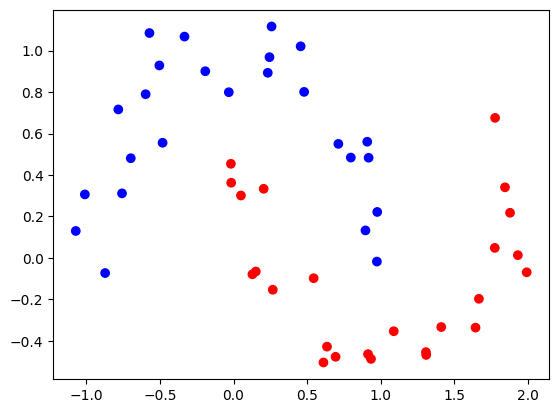

In [15]:
# Read data.

# Path to data.
data_path = joinpath(@__DIR__, "../data/gp-classify-data-N50.json")

# Load data in JSON format.
data = let
    x = open(f -> read(f, String), data_path)
    JSON3.read(x)
end

# Store data.
X = [data["x1"] data["x2"]]
y = Int64.(data["y"])

# Plot data.
plot_data(X, y);

In [41]:
# Create model.
m =  GPClassify(Float64.(y), X);
kernel_params = [:alpha, :rho, :beta];

In [42]:
# Fit via ADVI.
Random.seed!(7)

# initialize variational distribution (optional)
q0 = Variational.meanfield(m)

# NOTE: ADVI(num_elbo_samples, max_iters)

# Compile
@time q = vi(m, ADVI(1, 1), q0, optimizer=Flux.ADAM(1e-1));

# RUN
@time q = vi(m, ADVI(1, 1000))#, q0, optimizer=Flux.ADAM(1e-1));
 
# Get posterior samples
extract_gp = make_extractor(m, q, nsamples=500)
advi_samples = Dict{Symbol, Any}(sym => vec(extract_gp(sym)) for sym in kernel_params)
# advi_samples[:f] = extract_gp(:f);
advi_samples[:eta] = extract_gp(:eta);

  5.233591 seconds (13.25 M allocations: 639.518 MiB, 2.50% gc time)


┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 4586871771804480123
└ @ Turing.Variational /home/ubuntu/.julia/packages/Turing/NZ9IU/src/variational/VariationalInference.jl:204


 16.767138 seconds (66.16 M allocations: 20.580 GiB, 9.77% gc time)


98.8%┣███████████████████████████████████████▌┫ 494/500 [00:12<00:00, 41.6 it/s]

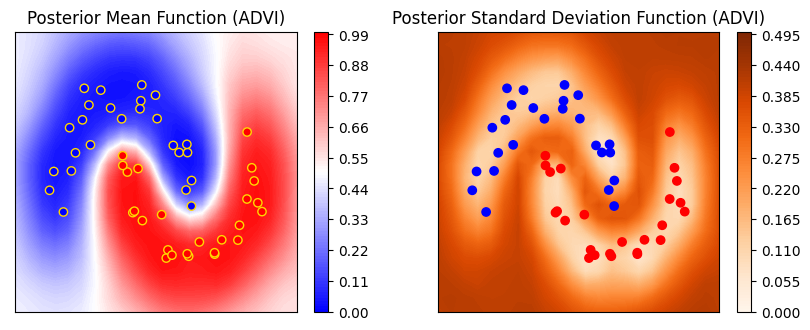

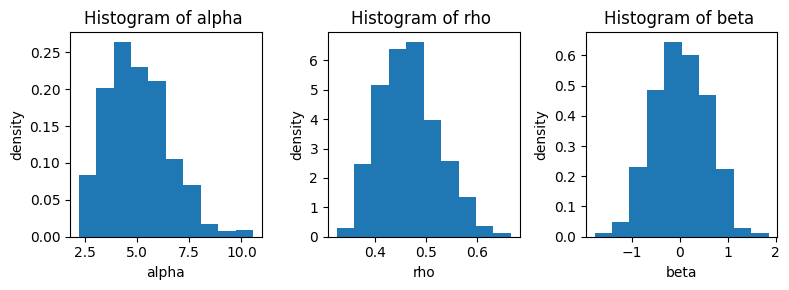

100.0%┣███████████████████████████████████████┫ 500/500 [00:12<00:00, 41.5 it/s]


In [43]:
plot_uq(advi_samples, X, y, "ADVI", eps=0.5,
        nnew=500, data_edgecolors="gold",
        kernel_params=kernel_params,
        color_res=range(0, 1, length=101),
        color_res_sd=range(0, .5, length=101));

## HMC

- stepsize = 0.05
- num leapfrog steps = 20
- burn in: 500
- samples: 500

In [44]:
# Fit via HMC.
Random.seed!(0)
burn = 500
nsamples = 500

# Compile
@time _ = sample(m, HMC(0.01, 1), 1)

# Run
@time hmc_chain = sample(m, HMC(0.05, 20), burn + nsamples);

# Get posterior samples
hmc_samples = Dict{Symbol, Any}([
    sym => vec(group(hmc_chain, sym).value.data)[end-nsamples+1:end]
for sym in kernel_params])
# hmc_samples[:f] = Matrix(group(hmc_chain, :f).value.data[end-nsamples+1:end, :, 1]');
hmc_samples[:eta] = Matrix(group(hmc_chain, :eta).value.data[end-nsamples+1:end, :, 1]');

  9.112223 seconds (23.87 M allocations: 1.129 GiB, 2.54% gc time)


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47


 71.610626 seconds (354.67 M allocations: 197.890 GiB, 12.90% gc time)


98.6%┣███████████████████████████████████████▍┫ 493/500 [00:12<00:00, 41.0 it/s]

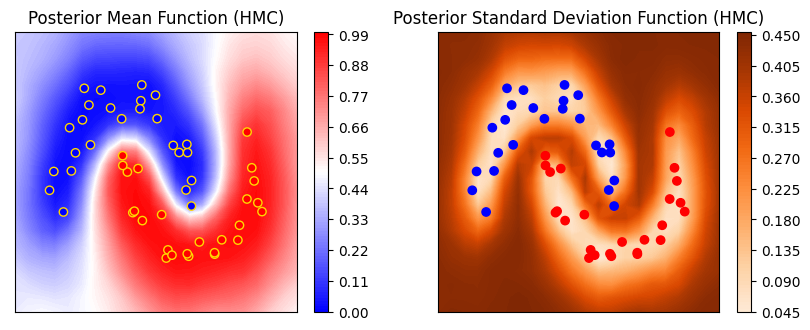

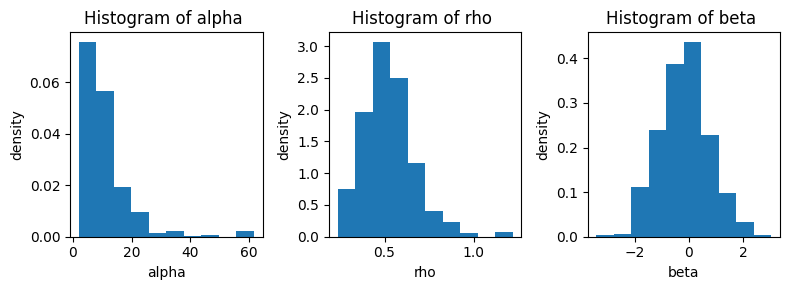

100.0%┣███████████████████████████████████████┫ 500/500 [00:12<00:00, 41.1 it/s]


In [45]:
# Plot HMC
ps, Xnew, grid = plot_uq(hmc_samples, X, y, "HMC", eps=0.5,
                         nnew=500, data_edgecolors="gold",
                         kernel_params=kernel_params,
                         color_res=range(0, 1, length=101),
                         return_stuff=true);

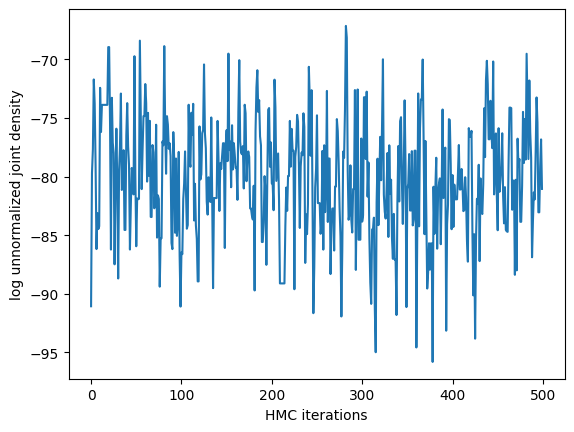

In [22]:
plt.plot(get(hmc_chain, :lp)[1].data[burn+1:end]);
plt.xlabel("HMC iterations");
plt.ylabel("log unnormalized joint density");

In [37]:
# Fit via NUTS.
Random.seed!(0)
burn = 500
nsamples = 500

# Compile
@time _ = sample(m, NUTS(1, 0.8, max_depth=2), 2)

# Run
@time nuts_chain = sample(m, NUTS(burn, 0.8, max_depth=10), burn + nsamples);

# Get posterior samples
nuts_samples = Dict{Symbol, Any}([
    sym => vec(group(nuts_chain, sym).value.data)[end-nsamples+1:end]
for sym in kernel_params])
# nuts_samples[:f] = Matrix(group(nuts_chain, :f).value.data[end-nsamples+1:end, :, 1]');
nuts_samples[:eta] = Matrix(group(nuts_chain, :eta).value.data[end-nsamples+1:end, :, 1]');

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47


  0.429197 seconds (242.07 k allocations: 898.587 MiB, 9.27% gc time)


┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/ubuntu/.julia/packages/AdvancedHMC/P9wqk/src/ha

100.731817 seconds (61.74 M allocations: 293.493 GiB, 12.61% gc time)


99.6%┣███████████████████████████████████████▉┫ 498/500 [00:11<00:00, 43.5 it/s]

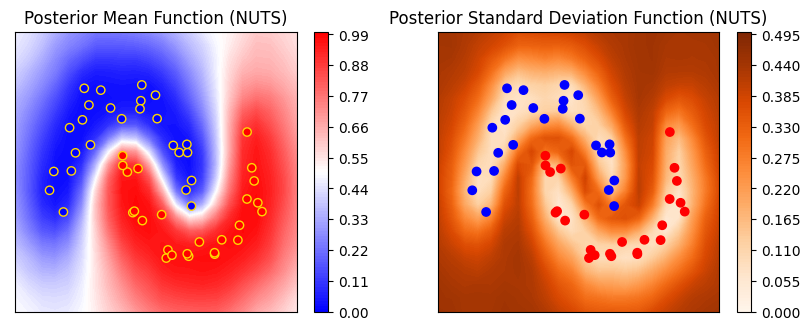

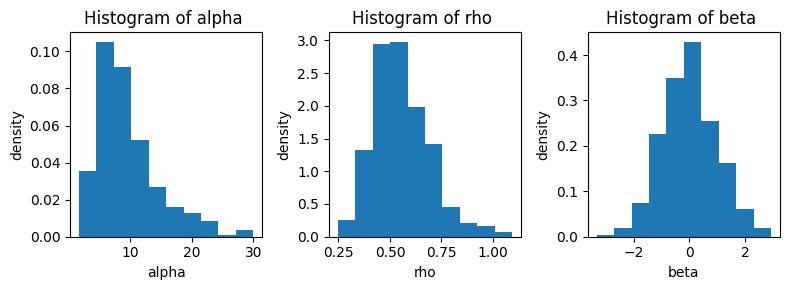

100.0%┣███████████████████████████████████████┫ 500/500 [00:11<00:00, 43.5 it/s]


In [38]:
# Plot NUTS
plot_uq(nuts_samples, X, y, "NUTS", eps=0.5,
        nnew=500, data_edgecolors="gold",
        kernel_params=kernel_params,
        color_res=range(0, 1, length=101),
        color_res_sd=range(0, .5, length=101),
        return_stuff=true);

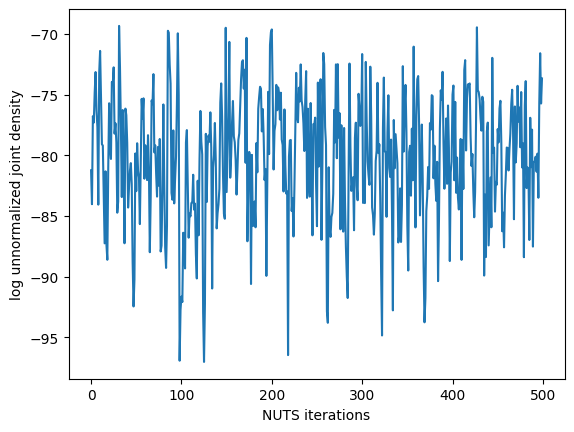

In [39]:
plt.plot(get(nuts_chain, :lp)[1].data);
plt.xlabel("NUTS iterations");
plt.ylabel("log unnormalized joint density");